# Google-Amazon Entity Matching Project

\- Snehila

This notebook implements a pipeline to match entities (products) between two datasets: Amazon and Google Products.

The tasks involve:


## Table of Contents:
Task 1
* [Task 1.1 Data Preparation](#first-bullet)
* [Task 1.2 Key features extraction and Blocking scheme implementation](#second-bullet)
* [Task 1.3 Similarity score calculation](#third-bullet)
* [Task 1.4 Accuracy of Pipeline](#fourth-bullet)



Task 2
* [Task 2.1 Creating training dataset](#fifth-bullet)
* [Task 2.2 Feature Engineering](#sixth-bullet)
* [Task 2.3 Dataset Preprocessing for training](#seventh-bullet)
* [Task 2.4 Model training and metric evaluation](#eigth-bullet)
* [Task 2.5 Hyper-parameter optimization](#ninth-bullet)

We need following libraries so we need to install them:

In [ ]:
!pip install numpy pandas matplotlib seaborn nltk gensim scikit-learn imbalanced-learn Levenshtein tqdm scipy 

In [1]:
import re
import numpy as np
import pandas as pd
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

import gensim.downloader as api


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay, 
    confusion_matrix, precision_score, recall_score, f1_score, 
    roc_auc_score, jaccard_score
)


from scipy.spatial.distance import cosine
from numpy.linalg import norm
from Levenshtein import distance as lev

from scipy.sparse import csr_matrix

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Task 1.1 Data Preparation <a class="anchor" id="first-bullet"></a>

In [3]:
amazon_df = pd.read_csv('Amazon-GoogleProducts/Amazon.csv', encoding='latin1')
google_df = pd.read_csv('Amazon-GoogleProducts/GoogleProducts.csv', encoding='latin1', na_values=[" ", "null"])
perfect_matching_df = pd.read_csv('Amazon-GoogleProducts/Amzon_GoogleProducts_perfectMapping.csv', encoding='latin1')

In [4]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1363 non-null   object 
 1   title         1363 non-null   object 
 2   description   1248 non-null   object 
 3   manufacturer  1363 non-null   object 
 4   price         1363 non-null   float64
dtypes: float64(1), object(4)
memory usage: 53.4+ KB


Observation: There are some null objects in 'description' column.

In [5]:
amazon_df.head()

,id,title,description,manufacturer,price
0,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),NaN,broderbund,0.00
1,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.00
2,b00004tkvy,noah's ark activity center (jewel case ages 3-8),NaN,victory multimedia,0.00
3,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99
4,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99


In [6]:
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3226 entries, 0 to 3225
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3226 non-null   object
 1   name          3226 non-null   object
 2   description   3035 non-null   object
 3   manufacturer  232 non-null    object
 4   price         3226 non-null   object
dtypes: object(5)
memory usage: 126.1+ KB


Observation: There are some null objects in 'description' and 'manufacturer' columns.

In [7]:
google_df.head()

,id,name,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1112...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99
1,http://www.google.com/base/feeds/snippets/1153...,superstart! fun with reading & writing!,fun with reading & writing! is designed to hel...,NaN,8.49
2,http://www.google.com/base/feeds/snippets/1134...,qb pos 6.0 basic software,qb pos 6.0 basic retail mngmt software. for re...,intuit,637.99
3,http://www.google.com/base/feeds/snippets/1204...,math missions: the amazing arcade adventure (g...,save spectacle city by disrupting randall unde...,NaN,12.95
4,http://www.google.com/base/feeds/snippets/1224...,production prem cs3 mac upgrad,adobe cs3 production premium mac upgrade from ...,adobe software,805.99


In [8]:
perfect_matching_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idAmazon      1300 non-null   object
 1   idGoogleBase  1300 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB


Observation: The headers for item names is different in google ('name') and amazon ('title') csvs, to maintain homogenity changing google header to 'title' aswell.

In [9]:
google_df.rename(columns={'name': 'title'}, inplace=True)

In [10]:
google_df.columns

Index(['id', 'title', 'description', 'manufacturer', 'price'], dtype='object')

In [11]:
amazon_df.columns

Index(['id', 'title', 'description', 'manufacturer', 'price'], dtype='object')

Observation: Replacing Nan values with empty string, to use vectorization later.

In [12]:
amazon_df.fillna(value=" ", inplace=True)
google_df.fillna(value=" ",inplace=True)

In [13]:
amazon_df.head()

,id,title,description,manufacturer,price
0,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),,broderbund,0.00
1,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.00
2,b00004tkvy,noah's ark activity center (jewel case ages 3-8),,victory multimedia,0.00
3,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99
4,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99


In [14]:
google_df.head()

,id,title,description,manufacturer,price
0,http://www.google.com/base/feeds/snippets/1112...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99
1,http://www.google.com/base/feeds/snippets/1153...,superstart! fun with reading & writing!,fun with reading & writing! is designed to hel...,,8.49
2,http://www.google.com/base/feeds/snippets/1134...,qb pos 6.0 basic software,qb pos 6.0 basic retail mngmt software. for re...,intuit,637.99
3,http://www.google.com/base/feeds/snippets/1204...,math missions: the amazing arcade adventure (g...,save spectacle city by disrupting randall unde...,,12.95
4,http://www.google.com/base/feeds/snippets/1224...,production prem cs3 mac upgrad,adobe cs3 production premium mac upgrade from ...,adobe software,805.99


Following data preprocess steps are performed on title, description and manufacturer fields of amazon and google dataframes:
- Convert all text to lowercase.
- Remove special characters and punctuation (e.g., commas, parentheses, etc.).
- Remove stopwords such as "the," "an," and "a."
- Replace empty strings and 'null' entries with actual null values.


In [15]:
def preprocess_text(input_text):
    lowercase_text = input_text.str.lower()
    tokenized_result = input_text.str.lower()

    stop_words = set(stopwords.words('english'))

    for idx in range(len(lowercase_text)):
        words = word_tokenize(lowercase_text[idx])
        
        filtered_words = [word for word in words if (word.isalpha() or word.isnumeric()) and word.isascii() and word not in stop_words]
        
        lowercase_text[idx] = ' '.join(filtered_words)

        tokenized_result[idx] = filtered_words

    return lowercase_text, tokenized_result


In [16]:
for column in ['title', 'description', 'manufacturer']:
    amazon_df[column + '_cleaned'], amazon_df[column + '_tokened'] = preprocess_text(amazon_df[column])       
    google_df[column + '_cleaned'], google_df[column + '_tokened'] = preprocess_text(google_df[column])  

In [17]:
google_df.head()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened
0,http://www.google.com/base/feeds/snippets/1112...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99,learning quickbooks 2007,"[learning, quickbooks, 2007]",learning quickbooks 2007,"[learning, quickbooks, 2007]",intuit,[intuit]
1,http://www.google.com/base/feeds/snippets/1153...,superstart! fun with reading & writing!,fun with reading & writing! is designed to hel...,,8.49,superstart fun reading writing,"[superstart, fun, reading, writing]",fun reading writing designed help kids learn r...,"[fun, reading, writing, designed, help, kids, ...",,[]
2,http://www.google.com/base/feeds/snippets/1134...,qb pos 6.0 basic software,qb pos 6.0 basic retail mngmt software. for re...,intuit,637.99,qb pos basic software,"[qb, pos, basic, software]",qb pos basic retail mngmt software retailers n...,"[qb, pos, basic, retail, mngmt, software, reta...",intuit,[intuit]
3,http://www.google.com/base/feeds/snippets/1204...,math missions: the amazing arcade adventure (g...,save spectacle city by disrupting randall unde...,,12.95,math missions amazing arcade adventure grades,"[math, missions, amazing, arcade, adventure, g...",save spectacle city disrupting randall underli...,"[save, spectacle, city, disrupting, randall, u...",,[]
4,http://www.google.com/base/feeds/snippets/1224...,production prem cs3 mac upgrad,adobe cs3 production premium mac upgrade from ...,adobe software,805.99,production prem mac upgrad,"[production, prem, mac, upgrad]",adobe production premium mac upgrade productio...,"[adobe, production, premium, mac, upgrade, pro...",adobe software,"[adobe, software]"


In [18]:
amazon_df.head()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened
0,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),,broderbund,0.00,clickart 950 000 premier image pack,"[clickart, 950, 000, premier, image, pack]",,[],broderbund,[broderbund]
1,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.00,ca international arcserve oem,"[ca, international, arcserve, oem]",oem arcserve backup win laptops desktops,"[oem, arcserve, backup, win, laptops, desktops]",computer associates,"[computer, associates]"
2,b00004tkvy,noah's ark activity center (jewel case ages 3-8),,victory multimedia,0.00,noah ark activity center jewel case ages,"[noah, ark, activity, center, jewel, case, ages]",,[],victory multimedia,"[victory, multimedia]"
3,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99,peachtree sage premium accounting nonprofits 2007,"[peachtree, sage, premium, accounting, nonprof...",peachtree premium accounting nonprofits 2007 a...,"[peachtree, premium, accounting, nonprofits, 2...",sage software,"[sage, software]"
4,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99,singing coach unlimited,"[singing, coach, unlimited]",singing coach unlimited electronic learning pr...,"[singing, coach, unlimited, electronic, learni...",technologies,[technologies]


Applying TF-IDF transformation on title_cleaned, description_cleaned and manufcaturer_cleaned columns of combined dataset (amazon+google) and appending the vectors to respective dataframes. (for similarity score calculation later) 

In [19]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
def compute_tfidf(df, column):
      # Limit feature size for efficiency
    tfidf_matrix = vectorizer.fit_transform(df[column])  # Keep sparse format
    return pd.Series(tfidf_matrix.toarray().tolist(), index=df.index, name=column + '_tfidf')

combined_df = pd.concat([google_df, amazon_df], ignore_index=True)

for column in ['title_cleaned', 'description_cleaned', 'manufacturer_cleaned']:
    combined_df[column + '_tfidf'] = compute_tfidf(combined_df, column)

combined_df.head()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened,title_cleaned_tfidf,description_cleaned_tfidf,manufacturer_cleaned_tfidf
0,http://www.google.com/base/feeds/snippets/1112...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99,learning quickbooks 2007,"[learning, quickbooks, 2007]",learning quickbooks 2007,"[learning, quickbooks, 2007]",intuit,[intuit],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,http://www.google.com/base/feeds/snippets/1153...,superstart! fun with reading & writing!,fun with reading & writing! is designed to hel...,,8.49,superstart fun reading writing,"[superstart, fun, reading, writing]",fun reading writing designed help kids learn r...,"[fun, reading, writing, designed, help, kids, ...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,http://www.google.com/base/feeds/snippets/1134...,qb pos 6.0 basic software,qb pos 6.0 basic retail mngmt software. for re...,intuit,637.99,qb pos basic software,"[qb, pos, basic, software]",qb pos basic retail mngmt software retailers n...,"[qb, pos, basic, retail, mngmt, software, reta...",intuit,[intuit],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,http://www.google.com/base/feeds/snippets/1204...,math missions: the amazing arcade adventure (g...,save spectacle city by disrupting randall unde...,,12.95,math missions amazing arcade adventure grades,"[math, missions, amazing, arcade, adventure, g...",save spectacle city disrupting randall underli...,"[save, spectacle, city, disrupting, randall, u...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,http://www.google.com/base/feeds/snippets/1224...,production prem cs3 mac upgrad,adobe cs3 production premium mac upgrade from ...,adobe software,805.99,production prem mac upgrad,"[production, prem, mac, upgrad]",adobe production premium mac upgrade productio...,"[adobe, production, premium, mac, upgrade, pro...",adobe software,"[adobe, software]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.81394872..."


Computing word2vec embeddings, will be using for machine learning model training later.

In [20]:
word2vec_model = api.load("glove-wiki-gigaword-50")

def compute_word2vec(df, column, model):
    def get_avg_word2vec(tokens, model):
        word_vectors = []
        
        for token in tokens:
            if token in model:
                word_vectors.append(model[token])
        
        if word_vectors:
            return np.mean(word_vectors, axis=0)
        else:
            return np.zeros(model.vector_size)
    
    embeddings = df[column].apply(lambda x: get_avg_word2vec(x, model))
    
    return embeddings

for column in ['title_tokened', 'description_tokened', 'manufacturer_tokened']:
    word2vec_embeddings = compute_word2vec(combined_df, column, word2vec_model)
    
    combined_df[column + '_word2vec'] = word2vec_embeddings

combined_df.head()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened,title_cleaned_tfidf,description_cleaned_tfidf,manufacturer_cleaned_tfidf,title_tokened_word2vec,description_tokened_word2vec,manufacturer_tokened_word2vec
0,http://www.google.com/base/feeds/snippets/1112...,learning quickbooks 2007,learning quickbooks 2007,intuit,38.99,learning quickbooks 2007,"[learning, quickbooks, 2007]",learning quickbooks 2007,"[learning, quickbooks, 2007]",intuit,[intuit],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.23816334, -0.25968668, -0.03731967, 0.4004...","[-0.23816334, -0.25968668, -0.03731967, 0.4004...","[1.0116, -1.2698, 0.6479, 1.2672, -0.45815, 0...."
1,http://www.google.com/base/feeds/snippets/1153...,superstart! fun with reading & writing!,fun with reading & writing! is designed to hel...,,8.49,superstart fun reading writing,"[superstart, fun, reading, writing]",fun reading writing designed help kids learn r...,"[fun, reading, writing, designed, help, kids, ...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.53976995, 0.39738333, -0.5529867, -0.89661...","[0.0009067931, 0.051614575, -0.13169286, -0.54...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,http://www.google.com/base/feeds/snippets/1134...,qb pos 6.0 basic software,qb pos 6.0 basic retail mngmt software. for re...,intuit,637.99,qb pos basic software,"[qb, pos, basic, software]",qb pos basic retail mngmt software retailers n...,"[qb, pos, basic, retail, mngmt, software, reta...",intuit,[intuit],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5821625, -0.24627039, 0.60254, 0.7089813, ...","[-0.11362338, -0.37718737, 0.6135158, 0.165471...","[1.0116, -1.2698, 0.6479, 1.2672, -0.45815, 0...."
3,http://www.google.com/base/feeds/snippets/1204...,math missions: the amazing arcade adventure (g...,save spectacle city by disrupting randall unde...,,12.95,math missions amazing arcade adventure grades,"[math, missions, amazing, arcade, adventure, g...",save spectacle city disrupting randall underli...,"[save, spectacle, city, disrupting, randall, u...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.053794008, 0.31814533, -0.1874665, -0.22078...","[0.3362187, -0.080503836, -0.044439573, 0.0227...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,http://www.google.com/base/feeds/snippets/1224...,production prem cs3 mac upgrad,adobe cs3 production premium mac upgrade from ...,adobe software,805.99,production prem mac upgrad,"[production, prem, mac, upgrad]",adobe production premium mac upgrade productio...,"[adobe, production, premium, mac, upgrade, pro...",adobe software,"[adobe, software]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.81394872...","[0.13556266, -0.64813, 0.09702164, 0.27962667,...","[0.13018022, -0.011586893, 0.5307831, 0.168604...","[0.51927495, -0.686065, 1.1335499, 0.871665, -..."


In [21]:
google_tfidf = combined_df.iloc[:3226,:]
amazon_tfidf = combined_df.iloc[3226:,:]

In [22]:
amazon_tfidf.head()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened,title_cleaned_tfidf,description_cleaned_tfidf,manufacturer_cleaned_tfidf,title_tokened_word2vec,description_tokened_word2vec,manufacturer_tokened_word2vec
3226,b000jz4hqo,clickart 950 000 - premier image pack (dvd-rom),,broderbund,0.0,clickart 950 000 premier image pack,"[clickart, 950, 000, premier, image, pack]",,[],broderbund,[broderbund],"[0.43531424835966087, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.11072101, 0.377981, 0.7082161, -0.07728801,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.70166, -1.4963, -0.12009, 0.75088, -0.337, ..."
3227,b0006zf55o,ca international - arcserve lap/desktop oem 30pk,oem arcserve backup v11.1 win 30u for laptops ...,computer associates,0.0,ca international arcserve oem,"[ca, international, arcserve, oem]",oem arcserve backup win laptops desktops,"[oem, arcserve, backup, win, laptops, desktops]",computer associates,"[computer, associates]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3886195, -0.21883276, 0.23233, -0.04923749...","[-0.27444002, -0.40519917, 1.1045684, 0.202969...","[0.375942, -0.143675, 1.43725, 0.82414, 0.2951..."
3228,b00004tkvy,noah's ark activity center (jewel case ages 3-8),,victory multimedia,0.0,noah ark activity center jewel case ages,"[noah, ark, activity, center, jewel, case, ages]",,[],victory multimedia,"[victory, multimedia]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.48694506, 0.44662285, -0.13759801, 0.128197...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.24174, 0.18515499, 0.30426848, 1.173985, -..."
3229,b000g80lqo,peachtree by sage premium accounting for nonpr...,peachtree premium accounting for nonprofits 20...,sage software,599.99,peachtree sage premium accounting nonprofits 2007,"[peachtree, sage, premium, accounting, nonprof...",peachtree premium accounting nonprofits 2007 a...,"[peachtree, premium, accounting, nonprofits, 2...",sage software,"[sage, software]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.042768504, 0.039289985, 0.0690805, -0.09650...","[0.21197172, -0.0133902915, 0.35336322, 0.0717...","[0.306325, -0.31440502, 0.23041001, 0.39795002..."
3230,b0006se5bq,singing coach unlimited,singing coach unlimited - electronic learning ...,carry-a-tune technologies,99.99,singing coach unlimited,"[singing, coach, unlimited]",singing coach unlimited electronic learning pr...,"[singing, coach, unlimited, electronic, learni...",technologies,[technologies],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.5989267, 0.60512334, -0.51882005, -0.27981...","[-0.337409, 0.1615665, 0.3071659, 0.36875, -0....","[0.66733, -0.34991, 1.2809, 1.3735, -0.66909, ..."


In [23]:
google_tfidf.tail()

,id,title,description,manufacturer,price,title_cleaned,title_tokened,description_cleaned,description_tokened,manufacturer_cleaned,manufacturer_tokened,title_cleaned_tfidf,description_cleaned_tfidf,manufacturer_cleaned_tfidf,title_tokened_word2vec,description_tokened_word2vec,manufacturer_tokened_word2vec
3221,http://www.google.com/base/feeds/snippets/1487...,jumpstart(r) advanced 1st grade,prepare your child for the 1st grade and beyon...,,19.99,jumpstart r advanced grade,"[jumpstart, r, advanced, grade]",prepare child grade beyond jumpstart advanced ...,"[prepare, child, grade, beyond, jumpstart, adv...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.299295, 0.43246996, 0.67165244, -0.0611150...","[-0.16410165, 0.3967693, -0.15557647, -0.32992...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3222,http://www.google.com/base/feeds/snippets/1491...,ibm(r) viavoice(r) advanced edition 10,ibm viavoice advanced edition release 10 is a ...,,78.95,ibm r viavoice r advanced edition 10,"[ibm, r, viavoice, r, advanced, edition, 10]",ibm viavoice advanced edition release 10 produ...,"[ibm, viavoice, advanced, edition, release, 10...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.17343241598296852, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.25164002, 0.194586, 0.72601575, 0.74342674...","[0.12486558, -0.17500092, 0.74631536, 0.375963...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3223,http://www.google.com/base/feeds/snippets/1497...,xbox 360: gears of war,as marcus fenix you fight a war against the im...,,59.99,xbox 360 gears war,"[xbox, 360, gears, war]",marcus fenix fight war immense locust horde po...,"[marcus, fenix, fight, war, immense, locust, h...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.230405, -0.7816775, 0.769195, 0.15323251, -...","[0.26191813, -0.3581942, -0.021246424, -0.1198...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3224,http://www.google.com/base/feeds/snippets/1498...,documents to go premium 7.0,this pda software enables you to use your docu...,,49.99,documents go premium,"[documents, go, premium]",pda software enables use documents word excel ...,"[pda, software, enables, use, documents, word,...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2928253, 0.27528033, 0.58105665, -0.0629966...","[0.22193275, -0.27643183, 0.73619336, 0.368784...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3225,http://www.google.com/base/feeds/snippets/1499...,microsoft(r) picture it! digital image pro 9.0,picture it! digital image pro puts you in cont...,,99.87,microsoft r picture digital image pro,"[microsoft, r, picture, digital, image, pro]",picture digital image pro puts control photos ...,"[picture, digital, image, pro, puts, control, ...",,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.3241087, 0.03485058, 0.8464816, 0.6567817,...","[-0.0028791744, 0.1510693, 0.5324291, 0.350190...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Rechecking shape of amazon, google and combined dataframes.

In [24]:
amazon_tfidf.shape

(1363, 17)

In [25]:
google_tfidf.shape

(3226, 17)

In [26]:
combined_df.shape

(4589, 17)

Some graphs:

The function plot_top_terms visualizes the top n (default 10) terms with the highest TF-IDF scores from a given TF-IDF column. This can be used to identify most important words in the corpus.

    TF-IDF score indicates the importance of a word relative to the entire document corpus:
        A higher TF-IDF score means the word is more important or unique in that document relative to the whole corpus.
        A lower TF-IDF score means the word is common across the documents and doesn't carry as much significance.

In [27]:
def plot_top_terms(tfidf_column, column_name, vectorizer):
    # Sum TF-IDF scores across all documents
    term_scores = np.array(tfidf_column.tolist()).sum(axis=0)
    terms = vectorizer.get_feature_names_out()
    
    # Get top terms
    top_n = 10
    top_indices = np.argsort(term_scores)[::-1][:top_n]
    top_terms = [terms[i] for i in top_indices]
    top_values = term_scores[top_indices]

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_values, y=top_terms, palette="viridis")
    plt.title(f"Top TF-IDF Terms for {column_name}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Term")
    plt.show()

In [28]:
def plot_pca(tfidf_column):
    tfidf_array = np.array(tfidf_column.tolist())
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_array)

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', edgecolor='k', alpha=0.7)
    plt.title("PCA Visualization of Documents")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

Visualizing TF-IDF for title_cleaned


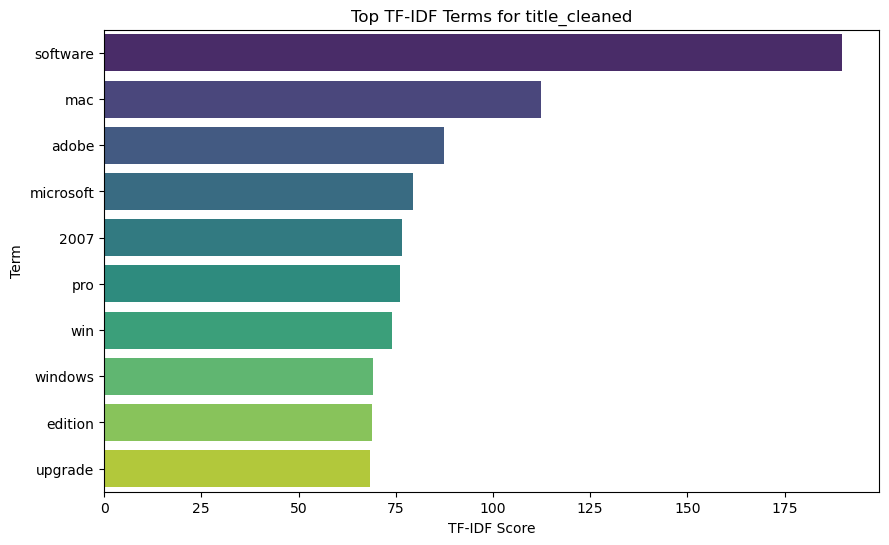

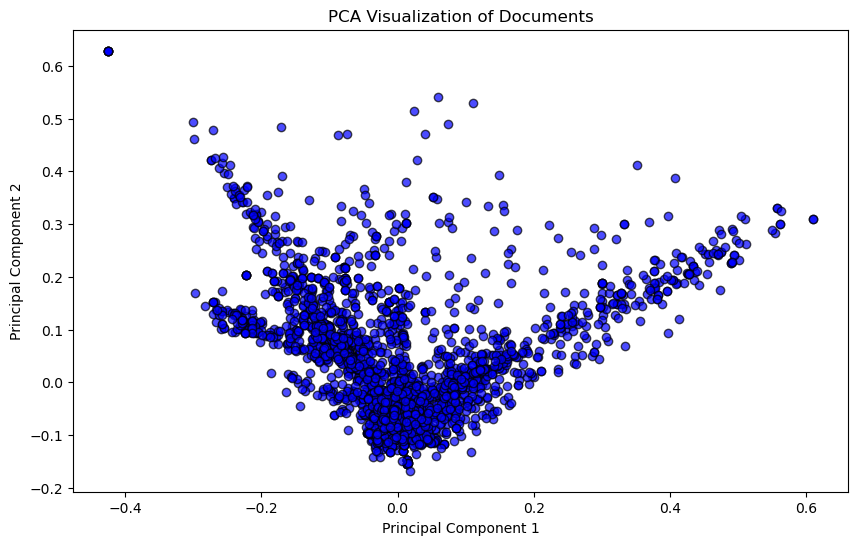

In [29]:
vectorizer.fit(combined_df['title_cleaned'])  # Fit vectorizer on original text
print(f"Visualizing TF-IDF for title_cleaned")
plot_top_terms(combined_df['title_cleaned' + '_tfidf'], 'title_cleaned', vectorizer)
plot_pca(combined_df['title_cleaned' + '_tfidf'])

Visualizing TF-IDF for manufacturer_cleaned


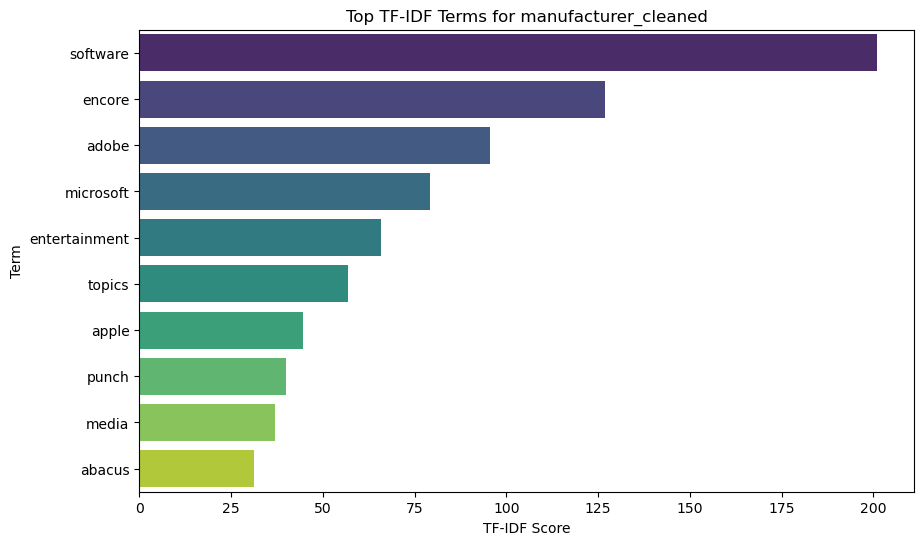

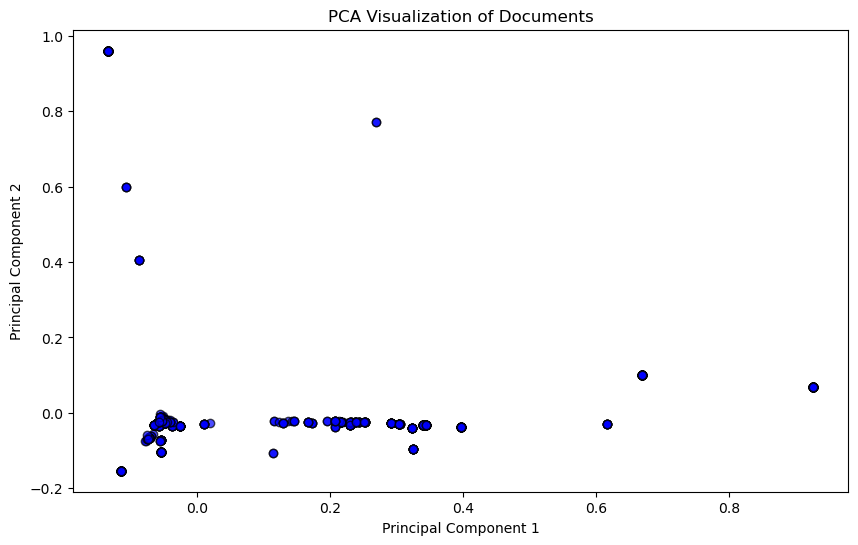

In [30]:
vectorizer.fit(combined_df['manufacturer_cleaned'])  # Fit vectorizer on original text
print(f"Visualizing TF-IDF for manufacturer_cleaned")
plot_top_terms(combined_df['manufacturer_cleaned' + '_tfidf'], 'manufacturer_cleaned', vectorizer)
plot_pca(combined_df['manufacturer_cleaned' + '_tfidf'])

Visualizing TF-IDF for description_cleaned


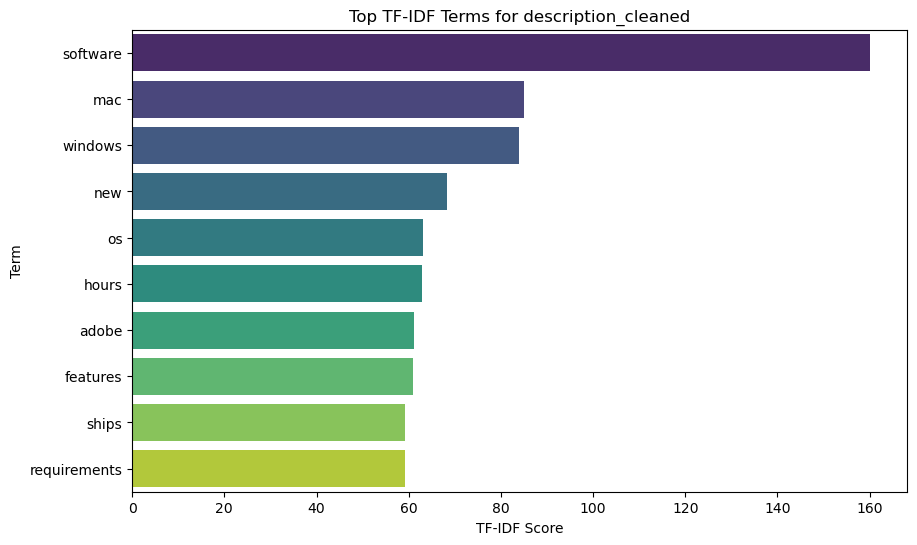

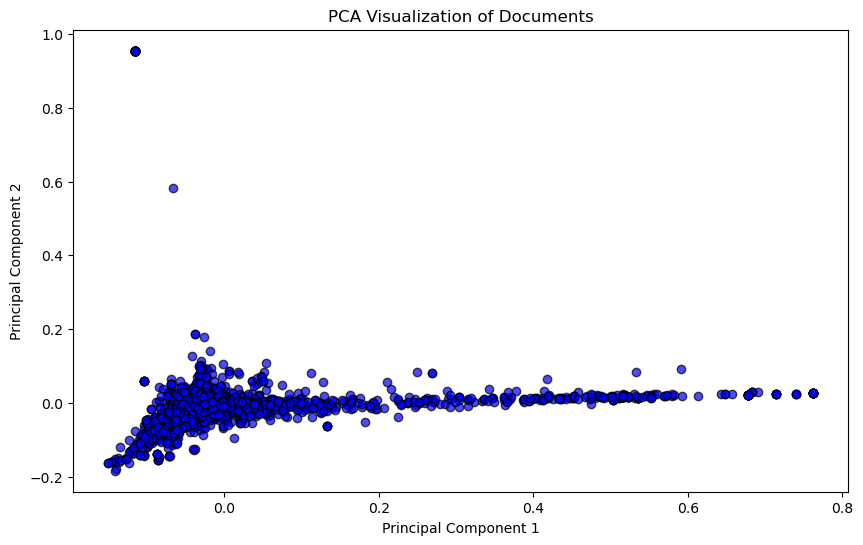

In [31]:
vectorizer.fit(combined_df['description_cleaned'])  # Fit vectorizer on original text
print(f"Visualizing TF-IDF for description_cleaned")
plot_top_terms(combined_df['description_cleaned' + '_tfidf'], 'description_cleaned', vectorizer)
plot_pca(combined_df['description_cleaned' + '_tfidf'])

## Task 1.2 Key features extraction and Blocking scheme implementation <a class="anchor" id="second-bullet"></a>

### Creating blocks based on 'title' column 

Creating blocks based on commom words in name of the products field seems a natural choice because the name column typically contains unique or semi-unique identifiers for products. Even with slight variations or errors, product names often provide sufficient information to differentiate between distinct records.

Blocking reduces the number of pairwise comparisons needed during entity resolution by grouping records into "blocks" of similar entities.

We will be implementing a blocking scheme based on the 'title' column for efficient record linkage between Amazon and Google datasets. The blocking approach includes generating blocks of tokenized titles grouping by shared tokens (all rows/index values in a block have shared token), filtering blocks to make sure a block contains atleast one record from both amazon and google datasets, and generating candidate pairs.

In [32]:
def generate_blocks(tokenized_data, word_to_indices):
    
    for i, tokens in enumerate(tokenized_data):
        for token in tokens:
            word_to_indices[token].append(i)

    return list(word_to_indices.values())

Making sure the filtered blocks are neither too small nor too large, and include indices from both Amazon and Google datasets.

In [33]:
def filter_blocks(blocks, lower_limit=1, upper_limit=50, amazon_range=(3226, 4589), google_range=(0, 3225)):

    return [
        block for block in blocks if (
            lower_limit <= len(block) <= upper_limit
            and any(amazon_range[0] <= i <= amazon_range[1] for i in block)
            and any(google_range[0] <= i <= google_range[1] for i in block)
        )
    ]

In [34]:
from collections import defaultdict

cleaned_tokenized_title = combined_df['title_tokened']
word_to_row_map = defaultdict(list)

name_blocks_cleaned = generate_blocks(cleaned_tokenized_title, word_to_row_map)

filtered_blocks = filter_blocks(name_blocks_cleaned)

In [35]:
name_pairs = set()

for block in filtered_blocks:
    block_pairs = set(product([combined_df.iloc[i,0] for i in block if 3226 <= i <= 4589],[combined_df.iloc[i,0] for i in block if 0 <= i <= 3225]))
    name_pairs.update(block_pairs)

In [36]:
candidate_pairs = []

for amazon_id, google_id in tqdm(name_pairs, desc='Processing blocks creation: '):
    amazon_row = pd.DataFrame(amazon_tfidf[amazon_tfidf['id']==amazon_id])
    google_row = pd.DataFrame(google_tfidf[google_tfidf['id']==google_id])

    pair_info = {
        'amazon_id': amazon_row.iloc[0,0],
        'google_id': google_row.iloc[0,0],
        'amazon_name_tfidf': amazon_row.iloc[0,11],
        'google_name_tfidf': google_row.iloc[0,11],
        'amazon_description_tfidf': amazon_row.iloc[0,12],
        'google_description_tfidf': google_row.iloc[0,12],
        'amazon_manufacturer_tfidf': amazon_row.iloc[0,13],
        'google_manufacturer_tfidf': google_row.iloc[0,13],
        'amazon_name_word2vec': amazon_row.iloc[0,14],
        'google_name_word2vec': google_row.iloc[0,14],
        'amazon_description_word2vec': amazon_row.iloc[0,15],
        'google_description_word2vec': google_row.iloc[0,15],
        'amazon_manufacturer_word2vec': amazon_row.iloc[0,16],
        'google_manufacturer_word2vec': google_row.iloc[0,16],

    }

    candidate_pairs.append(pair_info)

candidate_pairs_df = pd.DataFrame(candidate_pairs)
candidate_pairs_df.head(10)

Processing blocks creation: 100%|███████████████████████████████████████████████| 31733/31733 [01:03<00:00, 498.66it/s]


,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,amazon_description_word2vec,google_description_word2vec,amazon_manufacturer_word2vec,google_manufacturer_word2vec
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...","[-0.26084822, 0.01724341, 0.46876782, -0.43736...","[0.35662365, 0.02135137, 0.46467414, 0.2598060...","[0.375942, -0.143675, 1.43725, 0.82414, 0.2951...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...","[0.09347924, 0.44731346, -0.062766425, 0.00603...","[0.346912, -0.1936938, 0.38122448, 0.5293122, ...","[0.1731, -0.60537, 0.027205, 0.11299, 0.71236,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...","[0.11849094, 0.30965388, -0.02349209, -0.14549...","[0.37429622, 0.44233358, -0.123921424, 0.12212...","[0.47766, 0.70599496, -0.64242, 0.294293, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...","[-0.03987078, -0.07114401, 0.6176086, 0.510396...","[0.18851118, -0.102446176, 0.36257812, -0.0602...","[0.109430306, -0.45736048, 0.94557, 1.282155, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....","[0.28238127, 0.4646901, 0.13185157, 0.16032714...","[0.1342523, -0.2442958, 1.0036743, 0.50769347,...","[0.56096, 0.35555, -0.37645, 0.8328, -0.91744,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,b00002sam7,http://www.google.com/base/feeds/snippets/1349...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [37]:
print(candidate_pairs_df.shape)


(31733, 14)


In [38]:
print(len(candidate_pairs_df['amazon_name_tfidf'].iloc[0]))


4176


## Task 1.3 Similarity score calculation  <a class="anchor" id="third-bullet"></a>

Now we will calculate similarity scores between Amazon and Google records for the candidate pairs generated in the previous step. 

Similarity scores are computed for the name, description, and manufacturer fields using **cosine similarity**, followed by calculating an average similarity score for each pair. 

The scores are then appended to the candidate pairs dataframe.

In [39]:
def compute_similarity(vector1, vector2):
    if vector1 is None or vector2 is None:
        return 0
    try:
        similarity = np.dot(vector1, vector2) / (norm(vector1) * norm(vector2))
        return np.nan_to_num(similarity, nan=0)
    except Exception as e:
        print(f"Error computing similarity: {e}")
        return 0

In [40]:
for i in tqdm(range(len(candidate_pairs_df)), desc="Processing similarity score calculation: "):
    name_vector_amazon = candidate_pairs_df.loc[i, 'amazon_name_tfidf']
    name_vector_google = candidate_pairs_df.loc[i, 'google_name_tfidf']

    description_vector_amazon = candidate_pairs_df.loc[i, 'amazon_description_tfidf']
    description_vector_google = candidate_pairs_df.loc[i, 'google_description_tfidf']

    manufacturer_vector_amazon = candidate_pairs_df.loc[i, 'amazon_manufacturer_tfidf']
    manufacturer_vector_google = candidate_pairs_df.loc[i, 'google_manufacturer_tfidf']

    name_sim = compute_similarity(name_vector_amazon, name_vector_google)

    description_sim = compute_similarity(description_vector_amazon, description_vector_google)

    manufacturer_sim = compute_similarity(manufacturer_vector_amazon, manufacturer_vector_google)

    avg_similarity = np.mean([name_sim, description_sim, manufacturer_sim], axis=0)

    candidate_pairs_df.loc[i, 'avg_similarity'] = avg_similarity
    candidate_pairs_df.loc[i, 'name_similarity'] = name_sim
    candidate_pairs_df.loc[i, 'description_similarity'] = description_sim
    candidate_pairs_df.loc[i, 'manufacturer_similarity'] = manufacturer_sim

candidate_pairs_df.head(10)

Processing similarity score calculation:   0%|                                               | 0/31733 [00:00<?, ?it/s]C:\Users\Rahul\AppData\Local\Temp\ipykernel_14376\3390020702.py:5: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(vector1, vector2) / (norm(vector1) * norm(vector2))
C:\Users\Rahul\AppData\Local\Temp\ipykernel_14376\3390020702.py:5: RuntimeWarning: invalid value encountered in scalar divide
  similarity = np.dot(vector1, vector2) / (norm(vector1) * norm(vector2))
Processing similarity score calculation: 100%|██████████████████████████████████| 31733/31733 [02:25<00:00, 217.95it/s]


,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,amazon_description_word2vec,google_description_word2vec,amazon_manufacturer_word2vec,google_manufacturer_word2vec,avg_similarity,name_similarity,description_similarity,manufacturer_similarity
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...","[-0.26084822, 0.01724341, 0.46876782, -0.43736...","[0.35662365, 0.02135137, 0.46467414, 0.2598060...","[0.375942, -0.143675, 1.43725, 0.82414, 0.2951...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.165721,0.315508,0.181655,0.000000
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...","[0.09347924, 0.44731346, -0.062766425, 0.00603...","[0.346912, -0.1936938, 0.38122448, 0.5293122, ...","[0.1731, -0.60537, 0.027205, 0.11299, 0.71236,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.065871,0.177444,0.020169,0.000000
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...","[0.11849094, 0.30965388, -0.02349209, -0.14549...","[0.37429622, 0.44233358, -0.123921424, 0.12212...","[0.47766, 0.70599496, -0.64242, 0.294293, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.091965,0.247271,0.028625,0.000000
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...","[-0.03987078, -0.07114401, 0.6176086, 0.510396...","[0.18851118, -0.102446176, 0.36257812, -0.0602...","[0.109430306, -0.45736048, 0.94557, 1.282155, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.061127,0.000000,0.183380,0.000000
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....","[0.28238127, 0.4646901, 0.13185157, 0.16032714...","[0.1342523, -0.2442958, 1.0036743, 0.50769347,...","[0.56096, 0.35555, -0.37645, 0.8328, -0.91744,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.071478,0.214433,0.000000,0

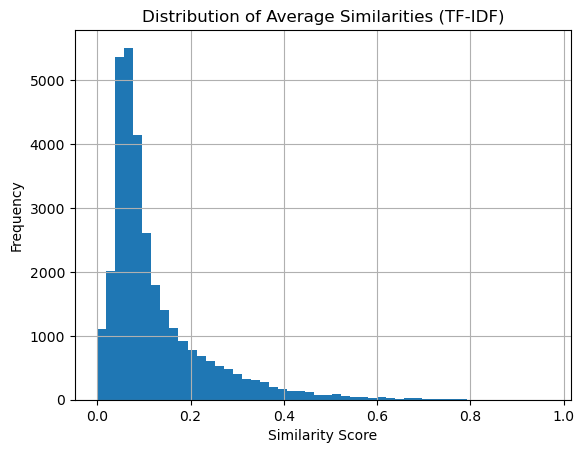

In [41]:
import matplotlib.pyplot as plt

candidate_pairs_df['avg_similarity'].hist(bins=50)
plt.title("Distribution of Average Similarities (TF-IDF)")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

<Axes: >

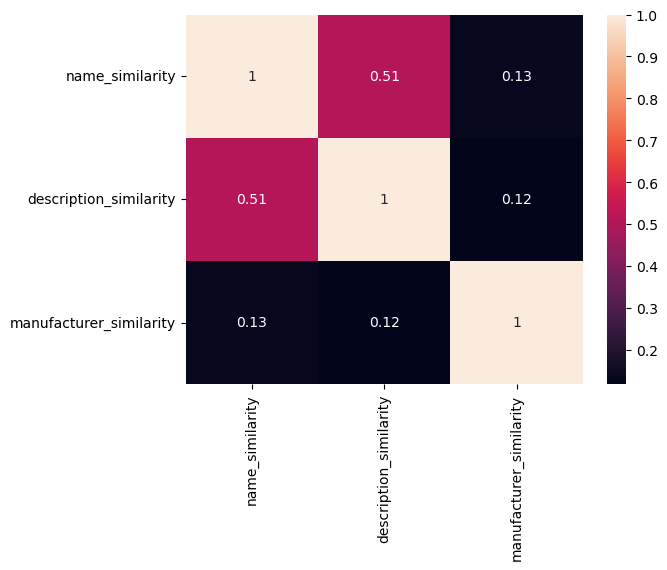

In [42]:
import seaborn as sns

sns.heatmap(candidate_pairs_df[['name_similarity', 'description_similarity', 'manufacturer_similarity']].corr(), annot=True)


Here, we can see name and description similarity scores are correlated, signifying if a product has similar name then it has similar description as well.

## Task 1.4 Accuracy of Pipeline <a class="anchor" id="fourth-bullet"></a>

In [43]:
ground_truth_pairs = set(zip(perfect_matching_df['idAmazon'], perfect_matching_df['idGoogleBase']))

In [44]:
thresholds = np.arange(0, 1.1, 0.1)

precision_list = []
recall_list = []
f1_score_list = []


for threshold in thresholds:
    filtered_pairs_df = candidate_pairs_df[candidate_pairs_df['avg_similarity'] >= threshold]
    filtered_pairs = set(zip(filtered_pairs_df['amazon_id'], filtered_pairs_df['google_id']))
    
    true_positive_pairs = filtered_pairs.intersection(ground_truth_pairs)
    num_true_positives = len(true_positive_pairs)
    
    precision = num_true_positives / len(filtered_pairs) if filtered_pairs else 0
    recall = num_true_positives / len(ground_truth_pairs)
    f1_score_result = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score_result)
    
    print(
        f"Threshold: {round(threshold, 1)} ---- True Positives: {num_true_positives}; "
        f"Precision: {round(precision, 4)}; Recall: {round(recall, 4)}; F1: {round(f1_score_result, 4)}"
    )


Threshold: 0.0 ---- True Positives: 1225; Precision: 0.0386; Recall: 0.9423; F1: 0.0742
Threshold: 0.1 ---- True Positives: 1222; Precision: 0.0934; Recall: 0.94; F1: 0.1699
Threshold: 0.2 ---- True Positives: 1107; Precision: 0.2027; Recall: 0.8515; F1: 0.3274
Threshold: 0.3 ---- True Positives: 748; Precision: 0.3052; Recall: 0.5754; F1: 0.3988
Threshold: 0.4 ---- True Positives: 341; Precision: 0.3324; Recall: 0.2623; F1: 0.2932
Threshold: 0.5 ---- True Positives: 128; Precision: 0.2876; Recall: 0.0985; F1: 0.1467
Threshold: 0.6 ---- True Positives: 62; Precision: 0.3196; Recall: 0.0477; F1: 0.083
Threshold: 0.7 ---- True Positives: 27; Precision: 0.4219; Recall: 0.0208; F1: 0.0396
Threshold: 0.8 ---- True Positives: 7; Precision: 0.5; Recall: 0.0054; F1: 0.0107
Threshold: 0.9 ---- True Positives: 1; Precision: 0.25; Recall: 0.0008; F1: 0.0015
Threshold: 1.0 ---- True Positives: 0; Precision: 0; Recall: 0.0; F1: 0


At 0.6 threshold of similarity score we have 62 matching pairs lets try to look into some of these matching pairs.

In [45]:
matching_pairs = candidate_pairs_df[candidate_pairs_df['avg_similarity'] >= 0.6]
matching_pairs = set(zip(matching_pairs['amazon_id'], matching_pairs['google_id']))
true_positive_pairs = matching_pairs.intersection(ground_truth_pairs)
print(f'Number of matching pairs with 0.6 similarity score threshold: {len(true_positive_pairs)}')
print('Following are matching pairs titles')
for i in range(len(true_positive_pairs)):
    amz_product = combined_df[combined_df['id'] == list(true_positive_pairs)[i][0]]
    google_product = combined_df[combined_df['id'] == list(true_positive_pairs)[i][1]]
    print(amz_product['title'])
    print(google_product['title'])
    print('---------------------------------------------------------------------------------------')

Number of matching pairs with 0.6 similarity score threshold: 62
Following are matching pairs titles
4512    webroot desktop firewall
Name: title, dtype: object
2336    webroot software 54210 desktop firewall
Name: title, dtype: object
---------------------------------------------------------------------------------------
4250    punch super home suite 3.0
Name: title, dtype: object
2936    punch software 17100 punch! super home suite
Name: title, dtype: object
---------------------------------------------------------------------------------------
4510    punch! master landscape & home design
Name: title, dtype: object
1062    punch software 25100 punch! master landscape a...
Name: title, dtype: object
---------------------------------------------------------------------------------------
3323    tournament poker 2005
Name: title, dtype: object
1637    eagle games egl 150 tournament poker - no limi...
Name: title, dtype: object
----------------------------------------------------------

As we can see most of the products are indeed similar.

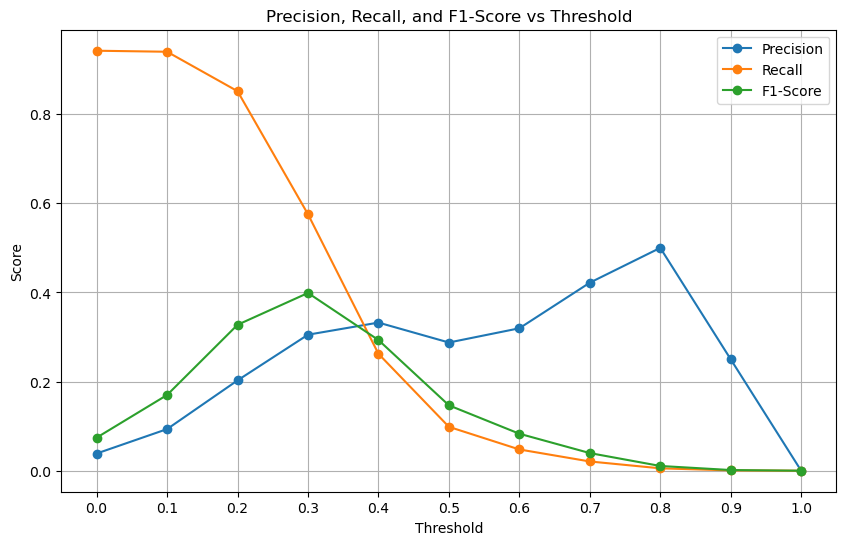

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='o')
plt.plot(thresholds, f1_score_list, label='F1-Score', marker='o')

plt.title('Precision, Recall, and F1-Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.legend()
plt.grid(True)
plt.show()

The best threshold is 0.3, best F1 is 0.3988

At 0.9 threshold, the number of True positives is 1.

## Task 2.1 Creating training dataset <a class="anchor" id="fifth-bullet"></a>

To create training dataset, we need to perform feature engineering to create new features, hence we need tokens of name, description and manufacturer as well. Performing a join below to merge tokens in our candidate dataframe.

In [47]:
candidate_pairs_df = pd.merge(candidate_pairs_df, amazon_tfidf, how='left', left_on='amazon_id', right_on='id')
candidate_pairs_df = candidate_pairs_df[['amazon_id', 'google_id', 'amazon_name_tfidf', 'google_name_tfidf', 'amazon_description_tfidf', 'google_description_tfidf', 'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf', 'amazon_name_word2vec', 'google_name_word2vec', 'amazon_description_word2vec', 'google_description_word2vec', 'amazon_manufacturer_word2vec', 'google_manufacturer_word2vec', 'avg_similarity', 'name_similarity', 'description_similarity','manufacturer_similarity','title', 'description', 'manufacturer', 'price', 'title_tokened', 'description_tokened', 'manufacturer_tokened']]
candidate_pairs_df.columns = ['amazon_id', 'google_id', 'amazon_name_tfidf', 'google_name_tfidf', 'amazon_description_tfidf', 'google_description_tfidf', 'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf', 'amazon_name_word2vec', 'google_name_word2vec', 'amazon_description_word2vec', 'google_description_word2vec', 'amazon_manufacturer_word2vec', 'google_manufacturer_word2vec', 'avg_similarity', 'name_similarity', 'description_similarity','manufacturer_similarity','amazon_name', 'amazon_description', 'amazon_manufacturer', 'amazon_price', 'amazon_title_tokened', 'amazon_description_tokened', 'amazon_manufacturer_tokened']


In [48]:
candidate_pairs_df

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,name_similarity,description_similarity,manufacturer_similarity,amazon_name,amazon_description,amazon_manufacturer,amazon_price,amazon_title_tokened,amazon_description_tokened,amazon_manufacturer_tokened
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,0.315508,0.181655,0.0,ca arcserve bkup protection suite exch r11.5 u...,arcserve bkup protection suite exch r11.5 upg-...,computer associates,0.0,"[ca, arcserve, bkup, protection, suite, exch, ...","[arcserve, bkup, protection, suite, exch, prod]","[computer, associates]"
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,0.177444,0.020169,0.0,riverdeep adventure workshop 4th-6th grade 8th...,adventure workshop 4th-6th grade 8th edition b...,riverdeep,0.0,"[riverdeep, adventure, workshop, grade, edition]","[adventure, workshop, grade, edition, brings, ...",[riverdeep]
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,0.247271,0.028625,0.0,jumpstart world 2nd grade,welcome to jumpstart world 2nd grade a series ...,knowledge adventure,19.99,"[jumpstart, world, grade]","[welcome, jumpstart, world, grade, series, 12,...","[knowledge, adventure]"
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,0.000000,0.183380,0.0,vegas 7 + dvd/soundforge8bundl,bonus as dvdp includes soundforge 8 software /...,sony media,722.0,"[vegas, 7]","[bonus, dvdp, includes, soundforge, 8, softwar...","[sony, media]"
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,0.214433,0.000000,0.0,family tree maker 11.2 collector's edition,whether you're an avid family historian or a c...,encore,109.95,"[family, tree, maker, collector, edition]","[whether, avid, family, historian, complete, n...

In [49]:
candidate_pairs_df = pd.merge(candidate_pairs_df, google_tfidf, how='left', left_on='google_id', right_on='id')
candidate_pairs_df = candidate_pairs_df[['amazon_id', 'google_id', 'amazon_name_tfidf', 'google_name_tfidf', 'amazon_description_tfidf', 'google_description_tfidf', 'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf', 'amazon_name_word2vec', 'google_name_word2vec', 'amazon_description_word2vec', 'google_description_word2vec', 'amazon_manufacturer_word2vec', 'google_manufacturer_word2vec', 'avg_similarity', 'name_similarity', 'description_similarity','manufacturer_similarity','amazon_name', 'amazon_description', 'amazon_manufacturer', 'amazon_price', 'amazon_title_tokened', 'amazon_description_tokened', 'amazon_manufacturer_tokened', 'title', 'description', 'manufacturer', 'price', 'title_tokened', 'description_tokened', 'manufacturer_tokened']]
candidate_pairs_df.columns = ['amazon_id', 'google_id', 'amazon_name_tfidf', 'google_name_tfidf', 'amazon_description_tfidf', 'google_description_tfidf', 'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf', 'amazon_name_word2vec', 'google_name_word2vec', 'amazon_description_word2vec', 'google_description_word2vec', 'amazon_manufacturer_word2vec', 'google_manufacturer_word2vec', 'avg_similarity', 'name_similarity', 'description_similarity','manufacturer_similarity','amazon_name', 'amazon_description', 'amazon_manufacturer', 'amazon_price', 'amazon_title_tokened', 'amazon_description_tokened', 'amazon_manufacturer_tokened', 'google_name', 'google_description', 'google_manufacturer', 'google_price', 'google_title_tokened', 'google_description_tokened', 'google_manufacturer_tokened']

In [50]:
candidate_pairs_df.tail(20)

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,amazon_title_tokened,amazon_description_tokened,amazon_manufacturer_tokened,google_name,google_description,google_manufacturer,google_price,google_title_tokened,google_description_tokened,google_manufacturer_tokened
31713,b00029bosq,http://www.google.com/base/feeds/snippets/1174...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10786499, 0.2481015, 0.4848475, -0.281205,...","[-0.03351667, 0.00754066, 0.52079993, 0.572034...",...,"[mighty, math, number, heroes]","[number, heroes, builds, math, skills, confide...",[edmark],encore software 12390 - math advantage 2008 - ...,encore software 12390 : math advantage? 2008 d...,,34.97,"[encore, software, 12390, math, advantage, 200...","[encore, software, 12390, math, advantage, 200...",[]
31714,b000h0k3zu,http://www.google.com/base/feeds/snippets/2971...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.06046451744805507, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.035780013, 0.45121333, 0.39352736, 0.41272...","[-0.193235, 0.71836, 0.20597774, 0.56652176, 0...",...,"[logic, express, 7]","[logic, express, gives, ability, take, full, a...","[apple, computer]",three-to-a-page 7 ring premier binder,padded 7-ring binder is for use with three-to-...,,31.99,"[7, ring, premier, binder]","[padded, binder, use, checks, stubs, available...",[]
31715,b000ab601m,http://www.google.com/base/feeds/snippets/1363...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3034894, -0.629074, 1.1777021, 0.49812603, ...","[0.22303873, -0.034603752, 0.5195425, 0.27171,...",...,"[microsoft, productivity, pack, windows, mobile]","[microsoft, entertainment, pack, 2004, win, ce...",[microsoft],633808344078 wasp mobileinventory combo pack -...,wasp bar code 633808344078 : usually ships in ...,,409.56,"[633808344078, wasp, mobileinventory, combo, p...","[wasp, bar, code, 633808344078, usually, ships...",[]
31716,b000hed3fs,http://www.google.com/base/feeds/snippets/6563...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.031082235, 0.26617712, 0.2223199, 0.216453...","[0.38969538, 0.24458401, 0.043128185, 0.218406...",...,"[family, tree, maker, version, 16, collectors,...","[family, tree, maker, version, 16, collector, ...","[encore, software]",apple .mac 4.0 family pack (new or renewal),here's what you get with a .mac membership! ea...,,145.99,"[apple, family, pack, new, renewal]","[get, membership, easily, publish, web, site, ...",[]
31717,b00009qenn,http://www.google.com/base/feeds/snippets/1811...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08412475, -0.5356

## Task 2.2 Feature Engineering (creating new features) <a class="anchor" id="sixth-bullet"></a>

We are going to consider following more features for name, description and manufacturer columns respectively:
- Levenshtein distance (for all 3): Levenshtein distance measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one string into another.
- Jaccard Similarity (for all 3): The Jaccard index measures similarity between two sets by dividing the size of their intersection by the size of their union.
- average of Levenshtein distances and Jaccard indices
- length difference (for name only): Measures the absolute difference in string lengths between amazon_name and google_name. Captures the structural disparity between the two strings.
- word overlap (for name only): Measures the count of common words between amazon_name and google_name. Helps identify semantic overlap.
- average word length (for name only): Measures the absolute difference in the average length of words in amazon_name and google_name.
- We have also considered mean values of every tf-idf columns

- Levenshtein calculation

In [51]:
def calculate_levenshtein(row):
    name_distance = lev(row['amazon_name'], row['google_name'])
    description_distance = lev(row['amazon_description'], row['google_description'])
    manufacturer_distance = lev(row['amazon_manufacturer'], row['google_manufacturer'])

    name_similarity = (1 - name_distance / max(len(row['amazon_name']), len(row['google_name']))) if max(len(row['amazon_name']), len(row['google_name'])) > 0 else 0
    description_similarity = (1 - description_distance / max(len(row['amazon_description']), len(row['google_description']))) if max(len(row['amazon_description']), len(row['google_description'])) > 0 else 0
    manufacturer_similarity = (1 - manufacturer_distance / max(len(row['amazon_manufacturer']), len(row['google_manufacturer']))) if max(len(row['amazon_manufacturer']), len(row['google_manufacturer'])) > 0 else 0

    result = pd.Series([name_distance, description_distance, manufacturer_distance, name_similarity, description_similarity, manufacturer_similarity])
    return result

In [52]:
from tqdm import tqdm
tqdm.pandas()

candidate_pairs_df[['name_lev', 'description_lev', 'manufacturer_lev', 'name_lev_similarity', 'description_lev_similarity', 'manufacturer_lev_similarity']] = candidate_pairs_df.progress_apply(calculate_levenshtein, axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 31733/31733 [00:20<00:00, 1527.23it/s]


In [53]:
candidate_pairs_df.head()

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,google_price,google_title_tokened,google_description_tokened,google_manufacturer_tokened,name_lev,description_lev,manufacturer_lev,name_lev_similarity,description_lev_similarity,manufacturer_lev_similarity
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,666.65,"[ca, business, protection, suite, microsoft, s...","[computer, associates, international, usually,...",[],61.0,203.0,18.0,0.351064,0.168033,0.052632
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,17.97,"[encore, software, 10941, frights, camera, mys...","[encore, software, 10941, encore, software, fr...",[],62.0,258.0,9.0,0.184211,0.175719,0.000000
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,12.9,"[topics, presents, museums, world]","[5, set, step, behind, velvet, rope, examine, ...",[],27.0,4545.0,18.0,0.181818,0.050554,0.052632
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,36.93,"[1460, vcom, systemsuite, professional, 7, com...","[bvrp, software, 1460, usually, ships, 24, hou...",[],73.0,182.0,9.0,0.130952,0.235294,0.100000
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,99.99,"[apple, ilife, family, pack]","[system, requirements, macintosh, computer, po...",[],35.0,241.0,6.0,0.166667,0.256173,0.000000


- Jaccard score calculation

In [54]:
mlb = MultiLabelBinarizer()

mlb.fit(
    candidate_pairs_df['amazon_title_tokened'].tolist() + 
    candidate_pairs_df['google_title_tokened'].tolist() +
    candidate_pairs_df['amazon_description_tokened'].tolist() + 
    candidate_pairs_df['google_description_tokened'].tolist() +
    candidate_pairs_df['amazon_manufacturer_tokened'].tolist() + 
    candidate_pairs_df['google_manufacturer_tokened'].tolist()
)

def calculate_jaccard_for_columns(row, mlb, columns):
    jaccard_scores = []
    
    for col1, col2 in columns:
        binary_sets = mlb.transform([row[col1], row[col2]])
        jaccard_scores.append(jaccard_score(binary_sets[0], binary_sets[1], zero_division=0))
    
    return pd.Series(jaccard_scores, index=['name_jaccard_similarity', 'description_jaccard_similarity', 'manufacturer_jaccard_similarity'])


In [55]:
columns_to_compare = [
    ('amazon_title_tokened', 'google_title_tokened'),
    ('amazon_description_tokened', 'google_description_tokened'),
    ('amazon_manufacturer_tokened', 'google_manufacturer_tokened')
]

candidate_pairs_df[['name_jaccard_similarity', 'description_jaccard_similarity', 'manufacturer_jaccard_similarity']] = candidate_pairs_df.progress_apply(
    calculate_jaccard_for_columns, mlb=mlb, columns=columns_to_compare, axis=1
)


100%|████████████████████████████████████████████████████████████████████████████| 31733/31733 [10:23<00:00, 50.91it/s]


In [56]:
candidate_pairs_df['avg_lev_similarity'] = candidate_pairs_df[['name_lev_similarity', 'description_lev_similarity', 
                                       'manufacturer_lev_similarity']].mean(axis=1)
candidate_pairs_df['avg_jaccard_similarity'] = candidate_pairs_df[['name_jaccard_similarity', 'description_jaccard_similarity', 
                                       'manufacturer_jaccard_similarity']].mean(axis=1)

In [57]:
def compute_vector_features(df, vector_columns):
    for col in vector_columns:
        df[f'{col}_mean'] = df[col].apply(lambda x: np.mean(x) if x else 0)
    return df

# Columns storing vectors
vector_columns = ['amazon_name_tfidf', 'google_name_tfidf',
                  'amazon_description_tfidf', 'google_description_tfidf',
                  'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf']

candidate_pairs_df = compute_vector_features(candidate_pairs_df, vector_columns)

In [58]:
candidate_pairs_df

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,description_jaccard_similarity,manufacturer_jaccard_similarity,avg_lev_similarity,avg_jaccard_similarity,amazon_name_tfidf_mean,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,0.076923,0.0,0.190576,0.097070,0.000664,0.000688,0.000436,0.000878,0.003947,0.0
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,0.028571,0.0,0.119976,0.035165,0.000528,0.000687,0.000920,0.000519,0.002793,0.0
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,0.016502,0.0,0.095001,0.061056,0.000414,0.000473,0.002026,0.000783,0.003950,0.0
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,0.060606,0.0,0.155415,0.047980,0.000239,0.000674,0.000543,0.000835,0.003945,0.0
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,0.000000,0.0,0.140947,0.041667,0.000525,0.000472,0.000875,0.000768,0.002793,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31728,b000e65hki,http://www.google.com/base/feeds/snippets/1719...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031530004, 0.31714332, -0.0313555, 0.205401...","[-0.39659265, 0.16291901, -0.19016331, -0.0409...",...,0.012658,0.0,0.163360,0.022738,0.000572,0.000783,0.001164,0.000896,0.003845,0.0
31729,b000099sie,http://www.google.com/base/feeds/sn

In [59]:
def length_difference(desc1, desc2):
    return abs(len(desc1) - len(desc2))

def word_overlap(desc1, desc2):
    words1 = set(desc1.split())
    words2 = set(desc2.split())
    return len(words1 & words2)

def avg_word_length(desc1, desc2):
    def avg_word_len(desc):
        words = desc.split()
        return np.mean([len(word) for word in words]) if words else 0
    return abs(avg_word_len(desc1) - avg_word_len(desc2))

In [60]:
def compute_features(desc1, desc2):
    return [
        length_difference(desc1, desc2),
        word_overlap(desc1, desc2),
        avg_word_length(desc1, desc2)
    ]

# Compute features for each pair
candidate_pairs_df['Features'] = candidate_pairs_df.apply(lambda row: compute_features(row['google_name'], row['amazon_name']), axis=1)

# Expand the features into separate columns
feature_columns = ["length_difference", "word_overlap", "avg_word_length"]
candidate_pairs_df[feature_columns] = pd.DataFrame(candidate_pairs_df['Features'].tolist(), index=candidate_pairs_df.index)


In [61]:
candidate_pairs_df.head(10)

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,amazon_name_tfidf_mean,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean,Features,length_difference,word_overlap,avg_word_length
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,0.000664,0.000688,0.000436,0.000878,0.003947,0.000000,"[32, 3, 1.6166666666666671]",32,3,1.616667
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,0.000528,0.000687,0.000920,0.000519,0.002793,0.000000,"[22, 1, 1.4404761904761898]",22,1,1.440476
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,0.000414,0.000473,0.002026,0.000783,0.003950,0.000000,"[8, 1, 0.2999999999999998]",8,1,0.300000
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,0.000239,0.000674,0.000543,0.000835,0.003945,0.000000,"[54, 1, 3.276315789473684]",54,1,3.276316
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,0.000525,0.000472,0.000875,0.000768,0.002793,0.000000,"[15, 1, 1.5666666666666673]",15,1,1.566667
5,b00002sam7,http://www.google.com/base/feeds/snippets/1349...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.47020704, 0.845798, -0.098519206, 0.2718780...","[0.65168536, 0.099435985, 0.55491483, 0.422954...",...,0.000527,0.000517,0.001101,0.000705,0.002793,0.000000,"[13, 2, 0.9107142857142856]",13,2,0.910714
6,b000h3lza4,http://www.google.com/base/feeds/snippets/6239...,"[0.0, 0.0, 0.0, 0.0, 0.0

In [62]:
candidate_pairs_df.columns

Index(['amazon_id', 'google_id', 'amazon_name_tfidf', 'google_name_tfidf',
       'amazon_description_tfidf', 'google_description_tfidf',
       'amazon_manufacturer_tfidf', 'google_manufacturer_tfidf',
       'amazon_name_word2vec', 'google_name_word2vec',
       'amazon_description_word2vec', 'google_description_word2vec',
       'amazon_manufacturer_word2vec', 'google_manufacturer_word2vec',
       'avg_similarity', 'name_similarity', 'description_similarity',
       'manufacturer_similarity', 'amazon_name', 'amazon_description',
       'amazon_manufacturer', 'amazon_price', 'amazon_title_tokened',
       'amazon_description_tokened', 'amazon_manufacturer_tokened',
       'google_name', 'google_description', 'google_manufacturer',
       'google_price', 'google_title_tokened', 'google_description_tokened',
       'google_manufacturer_tokened', 'name_lev', 'description_lev',
       'manufacturer_lev', 'name_lev_similarity', 'description_lev_similarity',
       'manufacturer_lev_simil

## Task 2.3 Training dataset preprocessing <a class="anchor" id="seventh-bullet"></a>

This preprocessing pipeline:

    1. Prepare the data by merging candidate pairs with known matches.
    2. Add a label (match) indicating whether a pair is a true match.
    3. Create new features (e.g., averages of similarity metrics).
    4. Select relevant features (X) for input into a machine learning model.

In [63]:
candidate_pairs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31733 entries, 0 to 31732
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   amazon_id                        31733 non-null  object 
 1   google_id                        31733 non-null  object 
 2   amazon_name_tfidf                31733 non-null  object 
 3   google_name_tfidf                31733 non-null  object 
 4   amazon_description_tfidf         31733 non-null  object 
 5   google_description_tfidf         31733 non-null  object 
 6   amazon_manufacturer_tfidf        31733 non-null  object 
 7   google_manufacturer_tfidf        31733 non-null  object 
 8   amazon_name_word2vec             31733 non-null  object 
 9   google_name_word2vec             31733 non-null  object 
 10  amazon_description_word2vec      31733 non-null  object 
 11  google_description_word2vec      31733 non-null  object 
 12  amazon_manufacture

In [64]:
merged_df = pd.merge(candidate_pairs_df, perfect_matching_df, how='left', left_on=['amazon_id', 'google_id'], right_on=['idAmazon', 'idGoogleBase'])
candidate_pairs_df['match'] = np.where(merged_df['idAmazon'].notnull(), 1, 0)
false_negatives = len(perfect_matching_df) - len(candidate_pairs_df[candidate_pairs_df['match']==1])

print("Number of FN: ", false_negatives)

Number of FN:  75


In [65]:
X = candidate_pairs_df[['avg_similarity', 'name_similarity', 'description_similarity','manufacturer_similarity','avg_lev_similarity', 'name_lev_similarity', 'description_lev_similarity', 'manufacturer_lev_similarity', 'avg_jaccard_similarity', 'name_jaccard_similarity', 'description_jaccard_similarity', 'manufacturer_jaccard_similarity', 'length_difference', 'word_overlap', 'avg_word_length', 'amazon_name_tfidf_mean', 'google_name_tfidf_mean', 'amazon_description_tfidf_mean', 'google_description_tfidf_mean', 'amazon_manufacturer_tfidf_mean', 'google_manufacturer_tfidf_mean']]
X.head(20)

,avg_similarity,name_similarity,description_similarity,manufacturer_similarity,avg_lev_similarity,name_lev_similarity,description_lev_similarity,manufacturer_lev_similarity,avg_jaccard_similarity,name_jaccard_similarity,...,manufacturer_jaccard_similarity,length_difference,word_overlap,avg_word_length,amazon_name_tfidf_mean,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean
0,0.165721,0.315508,0.181655,0.000000,0.190576,0.351064,0.168033,0.052632,0.097070,0.214286,...,0.00,32,3,1.616667,0.000664,0.000688,0.000436,0.000878,0.003947,0.000000
1,0.065871,0.177444,0.020169,0.000000,0.119976,0.184211,0.175719,0.000000,0.035165,0.076923,...,0.00,22,1,1.440476,0.000528,0.000687,0.000920,0.000519,0.002793,0.000000
2,0.091965,0.247271,0.028625,0.000000,0.095001,0.181818,0.050554,0.052632,0.061056,0.166667,...,0.00,8,1,0.300000,0.000414,0.000473,0.002026,0.000783,0.003950,0.000000
3,0.061127,0.000000,0.183380,0.000000,0.155415,0.130952,0.235294,0.100000,0.047980,0.083333,...,0.00,54,1,3.276316,0.000239,0.000674,0.000543,0.000835,0.003945,0.000000
4,0.071478,0.214433,0.000000,0.000000,0.140947,0.166667,0.256173,0.000000,0.041667,0.125000,...,0.00,15,1,1.566667,0.000525,0.000472,0.000875,0.000768,0.002793,0.000000
5,0.144386,0.257639,0.175518,0.000000,0.247366,0.442308,0.299790,0.000000,0.063919,0.111111,...,0.00,13,2,0.910714,0.000527,0.000517,0.001101,0.000705,0.002793,0.000000
6,0.386407,0.526021,0.244305,0.388897,0.253521,0.211268,0.114512,0.434783,0.154141,0.200000,...,0.25,24,2,0.125000,0.000384,0.000518,0.001846,0.000635,0.004737,0.003849
7,0.289070,0.491822,0.375388,0.000000,0.249071,0.376623,0.320588,0.050000,0.156911,0.300000,...,0.00,43,3,0.950000,0.000476,0.000705,0.000908,0.000759,0.003948,0.000000
8,0.083874,0.209418,0.042204,0.000000,0.190583,0.343750,0.228000,0.000000,0.045167,0.111111,...,0.00,2,1,2.050000,0.000535,0.000478,0.000875,0.000825,0.002793,0.000000
9,0.038993,0.116978,0.000000,0.000000,0.247845,0.157143,0.229249,0.357143,0.022222,0.066667,...,0.00,24,0,1.225000,0.000617,0.000670,0.000589,0.000794,0.002793,0.003845


In [66]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31733 entries, 0 to 31732
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   avg_similarity                   31733 non-null  float64
 1   name_similarity                  31733 non-null  float64
 2   description_similarity           31733 non-null  float64
 3   manufacturer_similarity          31733 non-null  float64
 4   avg_lev_similarity               31733 non-null  float64
 5   name_lev_similarity              31733 non-null  float64
 6   description_lev_similarity       31733 non-null  float64
 7   manufacturer_lev_similarity      31733 non-null  float64
 8   avg_jaccard_similarity           31733 non-null  float64
 9   name_jaccard_similarity          31733 non-null  float64
 10  description_jaccard_similarity   31733 non-null  float64
 11  manufacturer_jaccard_similarity  31733 non-null  float64
 12  length_difference 

## Task 2.4 Model training and Metric evaluation <a class="anchor" id="eigth-bullet"></a>

In [67]:
y=candidate_pairs_df['match']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Scaling the data because we will be using SVM, so we are going to use StandardScaler after splitting the data.

In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Since we have a highly imbalanced data, number of matching pairs is less than non-matching pairs, we need to apply handling data imbalance technique.

In [70]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

In [71]:
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("Class distribution after SMOTE:\n", y_train_res.value_counts())

Class distribution before SMOTE:
 0    24394
1      992
Name: match, dtype: int64
Class distribution after SMOTE:
 0    24394
1    24394
Name: match, dtype: int64


In [72]:
len(X_train)/len(candidate_pairs_df)

0.7999873948255759

**Random forest with k=3 cross validations**

Precision: 0.98
Recall: 1.00
F1-Score: 0.99


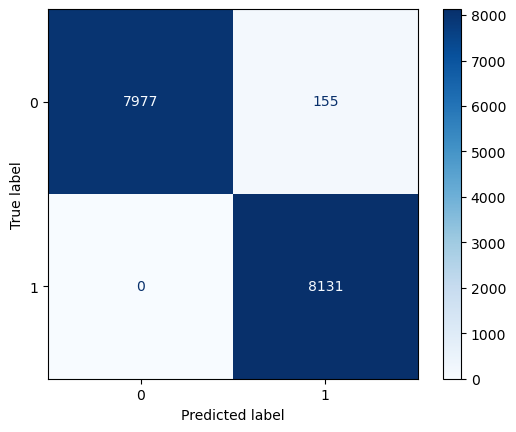

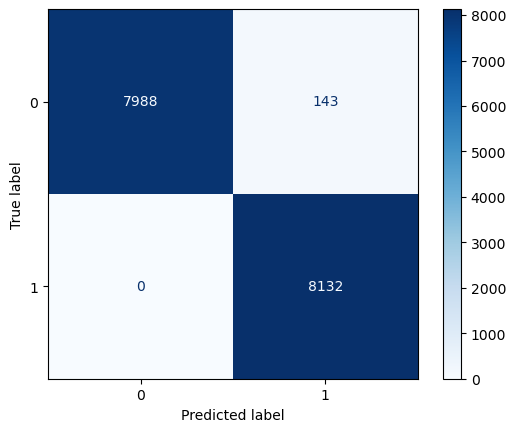

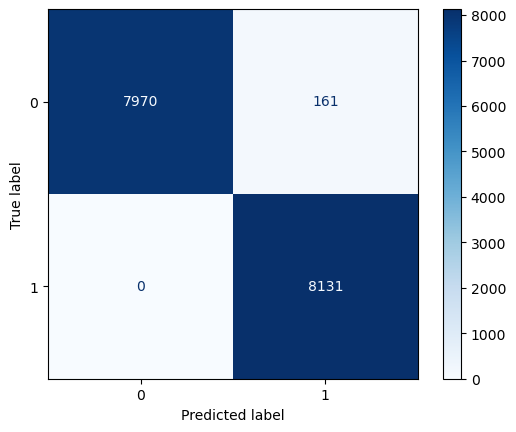

In [75]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in cv.split(X_train_res, y_train_res):
    X_train_fold, X_test_fold = X_train_res[train_index], X_train_res[test_index]
    y_train_fold, y_test_fold = y_train_res[train_index], y_train_res[test_index]
    
    rf_model = RandomForestClassifier(random_state=42)
    
    rf_model.fit(X_train_fold, y_train_fold)
    y_pred = rf_model.predict(X_test_fold)
    
    precision_scores.append(precision_score(y_test_fold, y_pred))
    recall_scores.append(recall_score(y_test_fold, y_pred))
    f1_scores.append(f1_score(y_test_fold, y_pred))
    
    cm = confusion_matrix(y_test_fold, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')

print(f"Precision: {np.mean(precision_scores):.2f}")
print(f"Recall: {np.mean(recall_scores):.2f}")
print(f"F1-Score: {np.mean(f1_scores):.2f}")

Let's check on unseen test data

Precision: 0.55
Recall: 0.56
F1-Score: 0.56


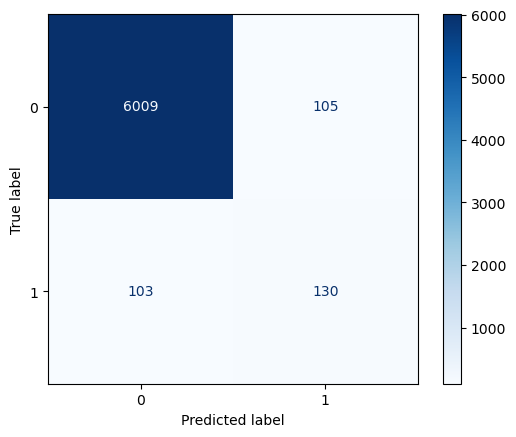

In [76]:
y_pred_rf = rf_model.predict(X_test_scaled)
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

The low f1 score on test data here, signifies model is overfitting on training data, we should try to use model which is less prone to overfitting like svm

**Support Vector Machine with k=3 cross validations**

Precision: 0.89
Recall: 0.92
F1-Score: 0.91


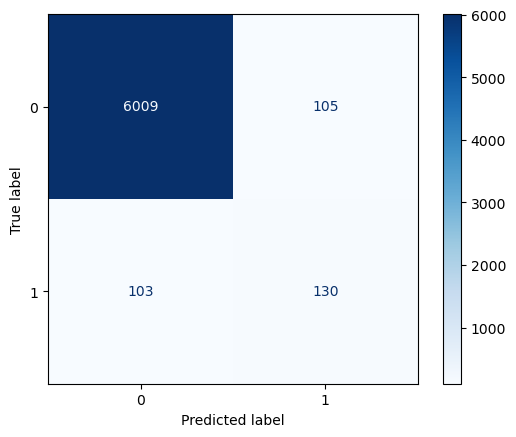

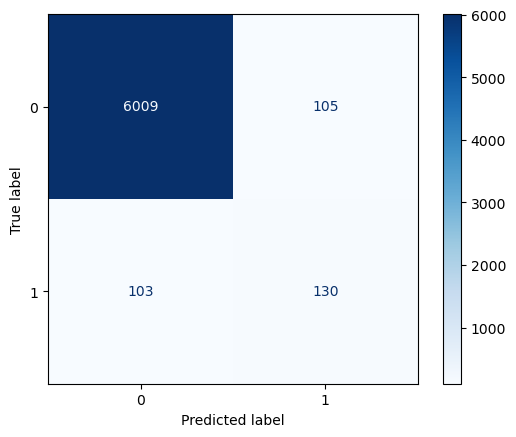

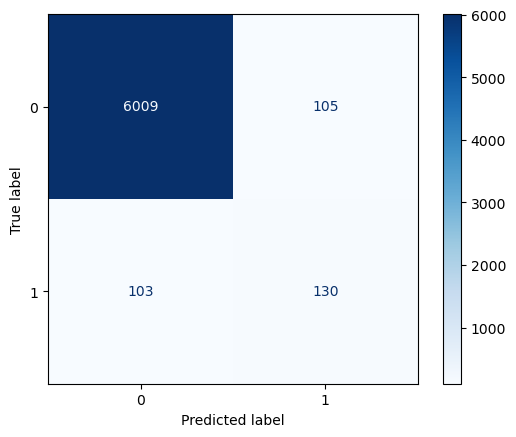

In [77]:
svm_model = SVC(random_state=42, kernel='linear')

precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in cv.split(X_train_res, y_train_res):
    X_train_fold, X_test_fold = X_train_res[train_index], X_train_res[test_index]
    y_train_fold, y_test_fold = y_train_res[train_index], y_train_res[test_index]

    svm_model.fit(X_train_fold, y_train_fold)
    y_pred = svm_model.predict(X_test_fold)

    precision_scores.append(precision_score(y_test_fold, y_pred))
    recall_scores.append(recall_score(y_test_fold, y_pred))
    f1_scores.append(f1_score(y_test_fold, y_pred))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')

print(f"Precision: {np.mean(precision_scores):.2f}")
print(f"Recall: {np.mean(recall_scores):.2f}")
print(f"F1-Score: {np.mean(f1_scores):.2f}")


Let's check on unseen test data

Precision: 0.24
Recall: 0.91
F1-Score: 0.38


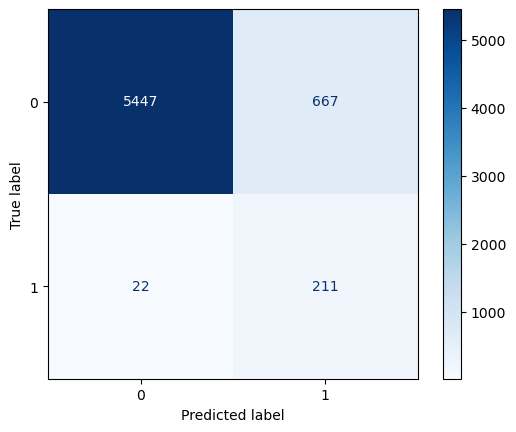

In [78]:
y_pred_svm = svm_model.predict(X_test_scaled)
print(f"Precision: {precision_score(y_test, y_pred_svm):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.2f}")

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

This is not doing any good than random forest, let's try to do hyperparameter optimization to find right parameters for random forest.

## Task 2.5 Hyper-parameter Optimization and more feature engineering <a class="anchor" id="ninth-bullet"></a>

Here, we will try to use word2vec embeddings after reducing dimension as training data.

In [79]:
candidate_pairs_df

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean,Features,length_difference,word_overlap,avg_word_length,match
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,0.000688,0.000436,0.000878,0.003947,0.0,"[32, 3, 1.6166666666666671]",32,3,1.616667,0
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,0.000687,0.000920,0.000519,0.002793,0.0,"[22, 1, 1.4404761904761898]",22,1,1.440476,0
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,0.000473,0.002026,0.000783,0.003950,0.0,"[8, 1, 0.2999999999999998]",8,1,0.300000,0
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,0.000674,0.000543,0.000835,0.003945,0.0,"[54, 1, 3.276315789473684]",54,1,3.276316,0
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,0.000472,0.000875,0.000768,0.002793,0.0,"[15, 1, 1.5666666666666673]",15,1,1.566667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31728,b000e65hki,http://www.google.com/base/feeds/snippets/1719...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031530004, 0.31714332, -0.0313555, 0.205401...","[-0.39659265, 0.16291901, -0.19016331, -0.0409...",...,0.000783,0.001164,0.000896,0.003845,0.0,"[50, 0, 0.40000000000000036]",50,0,0.400000,0
31729,b000099sie,http://www.google.com/base/feeds/snippets/6990...,"[0.0, 0.0, 0.0, 

In [80]:
X.head()

,avg_similarity,name_similarity,description_similarity,manufacturer_similarity,avg_lev_similarity,name_lev_similarity,description_lev_similarity,manufacturer_lev_similarity,avg_jaccard_similarity,name_jaccard_similarity,...,manufacturer_jaccard_similarity,length_difference,word_overlap,avg_word_length,amazon_name_tfidf_mean,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean
0,0.165721,0.315508,0.181655,0.0,0.190576,0.351064,0.168033,0.052632,0.097070,0.214286,...,0.0,32,3,1.616667,0.000664,0.000688,0.000436,0.000878,0.003947,0.0
1,0.065871,0.177444,0.020169,0.0,0.119976,0.184211,0.175719,0.000000,0.035165,0.076923,...,0.0,22,1,1.440476,0.000528,0.000687,0.000920,0.000519,0.002793,0.0
2,0.091965,0.247271,0.028625,0.0,0.095001,0.181818,0.050554,0.052632,0.061056,0.166667,...,0.0,8,1,0.300000,0.000414,0.000473,0.002026,0.000783,0.003950,0.0
3,0.061127,0.000000,0.183380,0.0,0.155415,0.130952,0.235294,0.100000,0.047980,0.083333,...,0.0,54,1,3.276316,0.000239,0.000674,0.000543,0.000835,0.003945,0.0
4,0.071478,0.214433,0.000000,0.0,0.140947,0.166667,0.256173,0.000000,0.041667,0.125000,...,0.0,15,1,1.566667,0.000525,0.000472,0.000875,0.000768,0.002793,0.0


In [81]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def convert_embeddings(df, columns):
    for col in columns:
        df[col] = df[col].apply(np.array)
    return df

embedding_columns = [
    'amazon_name_word2vec',
    'google_name_word2vec',
    'amazon_description_word2vec',
    'google_description_word2vec',
    'amazon_manufacturer_word2vec',
    'google_manufacturer_word2vec'
]

embed_to_arr = convert_embeddings(candidate_pairs_df, embedding_columns)

In [82]:
embed_to_arr

,amazon_id,google_id,amazon_name_tfidf,google_name_tfidf,amazon_description_tfidf,google_description_tfidf,amazon_manufacturer_tfidf,google_manufacturer_tfidf,amazon_name_word2vec,google_name_word2vec,...,google_name_tfidf_mean,amazon_description_tfidf_mean,google_description_tfidf_mean,amazon_manufacturer_tfidf_mean,google_manufacturer_tfidf_mean,Features,length_difference,word_overlap,avg_word_length,match
0,b000fbgapi,http://www.google.com/base/feeds/snippets/1367...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.10738558, 0.011773144, 0.591207, -0.30481,...","[0.31417042, 0.05389159, 0.2905901, 0.44183397...",...,0.000688,0.000436,0.000878,0.003947,0.0,"[32, 3, 1.6166666666666671]",32,3,1.616667,0
1,b000o3d94m,http://www.google.com/base/feeds/snippets/1399...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.108247995, 0.48419198, -0.389405, -0.10038...","[0.31340376, -0.1405235, 0.3662619, 0.39200276...",...,0.000687,0.000920,0.000519,0.002793,0.0,"[22, 1, 1.4404761904761898]",22,1,1.440476,0
2,b000i84dum,http://www.google.com/base/feeds/snippets/8175...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04598124...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.707...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.29276666, 0.6035066, 0.25765333, -0.333973...","[0.2396625, 1.016895, -0.60637003, 0.24843751,...",...,0.000473,0.002026,0.000783,0.003950,0.0,"[8, 1, 0.2999999999999998]",8,1,0.300000,0
3,b000nvspyo,http://www.google.com/base/feeds/snippets/1300...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005635008, 0.636885, 0.397385, 0.974175, -...","[-0.098278895, 0.39426446, 0.33650002, 0.22654...",...,0.000674,0.000543,0.000835,0.003945,0.0,"[54, 1, 3.276315789473684]",54,1,3.276316,0
4,b00023azve,http://www.google.com/base/feeds/snippets/1093...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12552336, 0.51925, -0.0665652, 0.313526, 0....","[0.67756176, 0.069375, 0.106205, 0.5789275, 0....",...,0.000472,0.000875,0.000768,0.002793,0.0,"[15, 1, 1.5666666666666673]",15,1,1.566667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31728,b000e65hki,http://www.google.com/base/feeds/snippets/1719...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.031530004, 0.31714332, -0.0313555, 0.205401...","[-0.39659265, 0.16291901, -0.19016331, -0.0409...",...,0.000783,0.001164,0.000896,0.003845,0.0,"[50, 0, 0.40000000000000036]",50,0,0.400000,0
31729,b000099sie,http://www.google.com/base/feeds/snippets/6990...,"[0.0, 0.0, 0.0, 

In [83]:
def combine_embeddings(df):
    combined_embeddings = []
    for index, row in df.iterrows():
        combined = np.concatenate([
            row['amazon_name_word2vec'],
            row['google_name_word2vec'],
            row['amazon_description_word2vec'],
            row['google_description_word2vec'],
            row['amazon_manufacturer_word2vec'],
            row['google_manufacturer_word2vec']
        ])
        combined_embeddings.append(combined)
    return np.array(combined_embeddings)

combined_embed = combine_embeddings(candidate_pairs_df)

In [84]:
combined_embed.shape

(31733, 300)

In [85]:
scaler = StandardScaler()
combined_embed_scaled = scaler.fit_transform(combined_embed)

pca = PCA(n_components=50) 
combined_embed_reduced = pca.fit_transform(combined_embed_scaled)

print(combined_embed_reduced.shape)  


(31733, 50)


In [86]:
X_with_embed = np.concatenate((X, combined_embed), axis=1)

In [87]:
X_with_embed.shape

(31733, 321)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_with_embed, y, test_size=0.2, random_state=0)

In [92]:
import optuna
print(optuna.__version__)

4.1.0


In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(10, 200),  # Number of trees
    "max_depth": randint(1, 20),      # Maximum depth of the tree
    "min_samples_split": randint(2, 20), 
    "min_samples_leaf": randint(1, 20)
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist, 
    n_iter=100, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

print(random_search.best_params_)


After performing hyperparameter optimization we get best hyperparameters and now we will train our model on whole dataset

Precision: 0.45
Recall: 0.73
F1-Score: 0.55


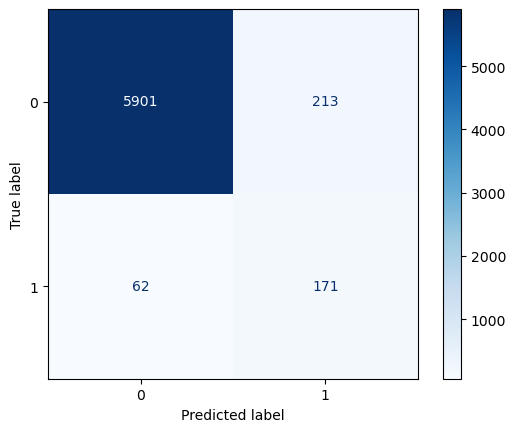

In [98]:
best_params_rf = {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 6}

final_rf_model = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)

# Train on entire training 
final_rf_model.fit(X_train_res, y_train_res)

y_pred_final_rf = final_rf_model.predict(X_test_scaled)

print(f"Precision: {precision_score(y_test, y_pred_final_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_final_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final_rf):.2f}")

cm = confusion_matrix(y_test, y_pred_final_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')